In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
df_atvi = pd.read_csv("atvi_weekly_return_detailed.csv")
df_spy = pd.read_csv("spy_weekly_return_detailed.csv")
df_atvi_vol = pd.read_csv("atvi_weekly_return_volatility.csv")
df_spy_vol = pd.read_csv("spy_weekly_return_volatility.csv")

In [3]:
df_atvi_yr1 = df_atvi[df_atvi["Year"] == 2021]
df_spy_yr1 = df_spy[df_spy["Year"] == 2021]
df_atvi_yr1_vol = df_atvi_vol[df_atvi_vol["Year"] == 2021]
df_spy_yr1_vol = df_spy_vol[df_spy_vol["Year"] == 2021]

df_atvi_yr2 = df_atvi[df_atvi["Year"] == 2022]
df_spy_yr2 = df_spy[df_spy["Year"] == 2022]
df_atvi_yr2_vol = df_atvi_vol[df_atvi_vol["Year"] == 2022]
df_spy_yr2_vol = df_spy_vol[df_spy_vol["Year"] == 2022]

In [4]:
def get_weekly_data(df_detailed, df_vol):
    df_weekly = pd.DataFrame(columns = df_atvi_yr1.columns)
    for i in range(df_vol.shape[0]):
        df_val = df_detailed[(df_vol.iloc[i, -5] == df_detailed["Week_Number"])]
        last_trading_day = df_val.iloc[-1, :]
        df_weekly = df_weekly.append(last_trading_day, ignore_index=True)
    df_weekly["True"] = ""
    for i in range(1, df_weekly.shape[0]):
        if df_weekly.iloc[i, 4] >= df_weekly.iloc[i-1, 4]:
            df_weekly.iat[i, -1] = "Green"
        else:
            df_weekly.iat[i, -1] = "Red"
    return df_weekly

In [5]:
df_atvi_weekly_yr1 = get_weekly_data(df_atvi_yr1, df_atvi_yr1_vol)
df_atvi_weekly_yr2 = get_weekly_data(df_atvi_yr2, df_atvi_yr2_vol)

df_spy_weekly_yr1 = get_weekly_data(df_spy_yr1, df_spy_yr1_vol)
df_spy_weekly_yr2 = get_weekly_data(df_spy_yr2, df_spy_yr2_vol)

In [6]:
def get_poly_model_and_predict(df_weekly, d):
    y_true = df_weekly["True"].values
    acc = []
    closings = df_weekly["Adj Close"].values
    w = np.arange(5, 13)
    for i in range(w.shape[0]):
        y_pred = []
        for j in range(df_weekly.shape[0] - w[i]):
            prev_days = df_weekly.iloc[j:j+w[i], :]
            x = np.arange(1, w[i]+1).reshape(-1, 1)
            y = prev_days["Adj Close"].values.reshape(-1, 1)
            poly_d = PolynomialFeatures(degree = d, include_bias=False)
            x_feat = poly_d.fit_transform(x)
            poly_d.fit(x_feat, y)
            reg_model = LinearRegression()
            reg_model.fit(x_feat, y)
            prediction_next = reg_model.predict(poly_d.fit_transform(np.array([w[i]+1]).reshape(-1, 1)))
            if prediction_next >= closings[j + w[i]]:
                y_pred.append("Green")
            else:
                y_pred.append("Red")
        y_pred = np.array(y_pred)
        accuracy = accuracy_score(y_true[w[i]:], y_pred)
        acc.append(accuracy)
    acc = np.array(acc)
    print(f"Best W for D = {d} -> {w[acc.argmax()]}")
    return acc

In [7]:
print("For Activision Blizzard -> ")
accuracy_atvi_d_1 = get_poly_model_and_predict(df_atvi_weekly_yr1, 1)
accuracy_atvi_d_2 = get_poly_model_and_predict(df_atvi_weekly_yr1, 2)
accuracy_atvi_d_3 = get_poly_model_and_predict(df_atvi_weekly_yr1, 3)
print("\nFor S&P 500 -> ")
accuracy_spy_d_1 = get_poly_model_and_predict(df_spy_weekly_yr1, 1)
accuracy_spy_d_2 = get_poly_model_and_predict(df_spy_weekly_yr1, 2)
accuracy_spy_d_3 = get_poly_model_and_predict(df_spy_weekly_yr1, 3)

For Activision Blizzard -> 
Best W for D = 1 -> 11
Best W for D = 2 -> 10
Best W for D = 3 -> 5

For S&P 500 -> 
Best W for D = 1 -> 10
Best W for D = 2 -> 5
Best W for D = 3 -> 10


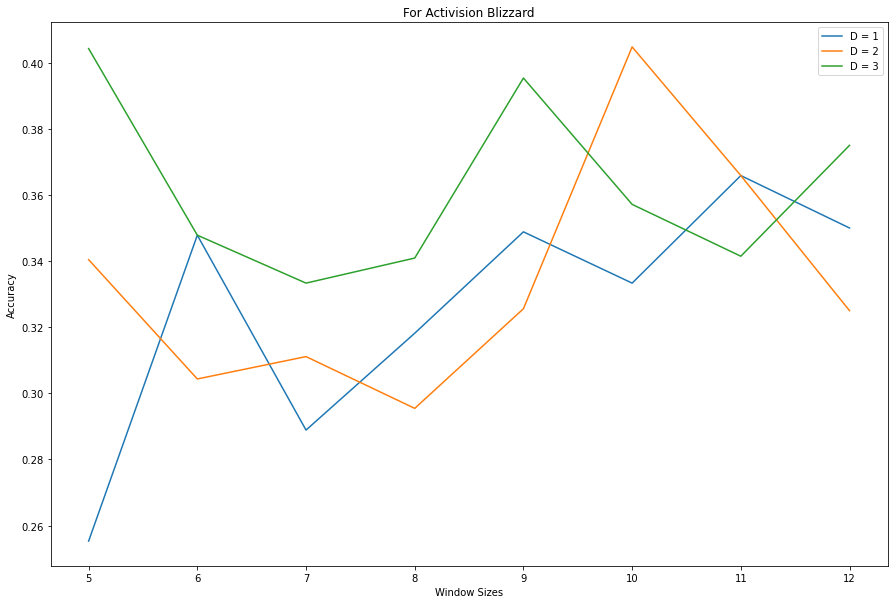

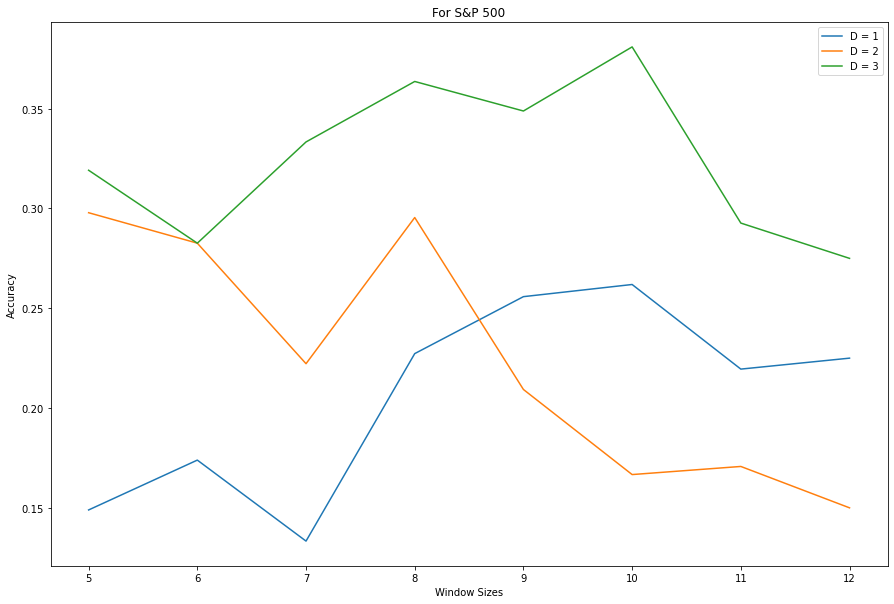

In [8]:
w = np.arange(5, 13)

plt.figure(figsize=(15, 10))
plt.plot(w, accuracy_atvi_d_1)
plt.plot(w, accuracy_atvi_d_2)
plt.plot(w, accuracy_atvi_d_3)
plt.title("For Activision Blizzard")
plt.xlabel("Window Sizes")
plt.ylabel("Accuracy")
plt.legend(["D = 1", "D = 2", "D = 3"])
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(w, accuracy_spy_d_1)
plt.plot(w, accuracy_spy_d_2)
plt.plot(w, accuracy_spy_d_3)
plt.title("For S&P 500")
plt.xlabel("Window Sizes")
plt.ylabel("Accuracy")
plt.legend(["D = 1", "D = 2", "D = 3"])
plt.show()
plt.show()

In [9]:
def predict_for_year2_metrics(df_weekly_yr2, d, w_best):
    closings = df_weekly_yr2["Adj Close"].values
    returns = df_weekly_yr2["Return"].values
    y_true = df_weekly_yr2["True"].values
    y_pred = []
    for j in range(df_weekly_yr2.shape[0] - w_best):
        prev_days = df_weekly_yr2.iloc[j:j+w_best, :]
        x = np.arange(1, w_best+1).reshape(-1, 1)
        y = prev_days["Adj Close"].values.reshape(-1, 1)
        poly_d = PolynomialFeatures(degree = d, include_bias=False)
        x_feat = poly_d.fit_transform(x)
        poly_d.fit(x_feat, y)
        reg_model = LinearRegression()
        reg_model.fit(x_feat, y)
        prediction_next = reg_model.predict(poly_d.fit_transform(np.array([w_best+1]).reshape(-1, 1)))
        if prediction_next >= closings[j + w_best]:
            y_pred.append("Green")
        else:
            y_pred.append("Red")
    y_pred = np.array(y_pred)
    
    accuracy = accuracy_score(y_true[w_best:], y_pred)
    print(f"Accuracy for D = {d} for best W = {w_best} -> {100*accuracy} %")
    conf_matrix = confusion_matrix(y_true[w_best:], y_pred)
    plt.figure()
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Red", "Green"])
    disp.plot()
    plt.show()
    returns = returns[w_best:]
    initial = 100
    vals = []
    for i in range(y_pred.shape[0]):
        if y_pred[i] == "Green":
            initial = initial*(1 + returns[i]/100)
        vals.append(initial)
    plt.figure(figsize=(15, 10))
    plt.plot(vals)
    plt.xlabel("Weeks Traded")
    plt.ylabel("Amount (in Dollars)")
    plt.title(f"Trading Strategy for D = {d} and W = {w_best}")
    plt.show()

For Activision Blizzard -> 
Accuracy for D = 1 for best W = 11 -> 31.70731707317073 %


<Figure size 432x288 with 0 Axes>

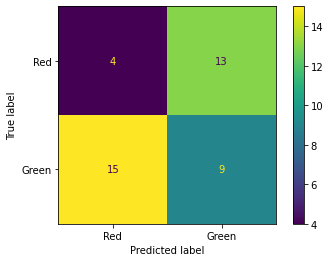

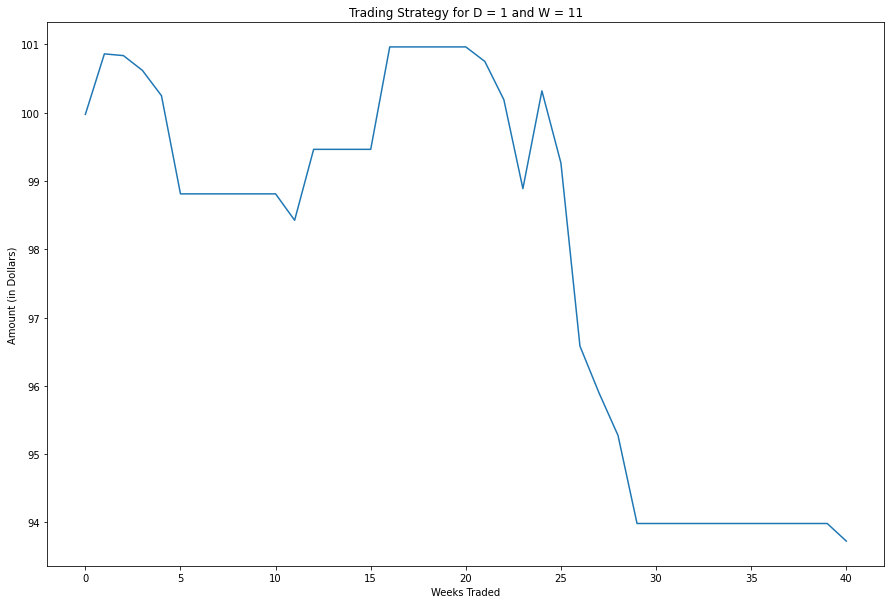

Accuracy for D = 2 for best W = 10 -> 33.33333333333333 %


<Figure size 432x288 with 0 Axes>

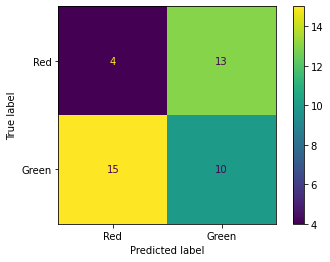

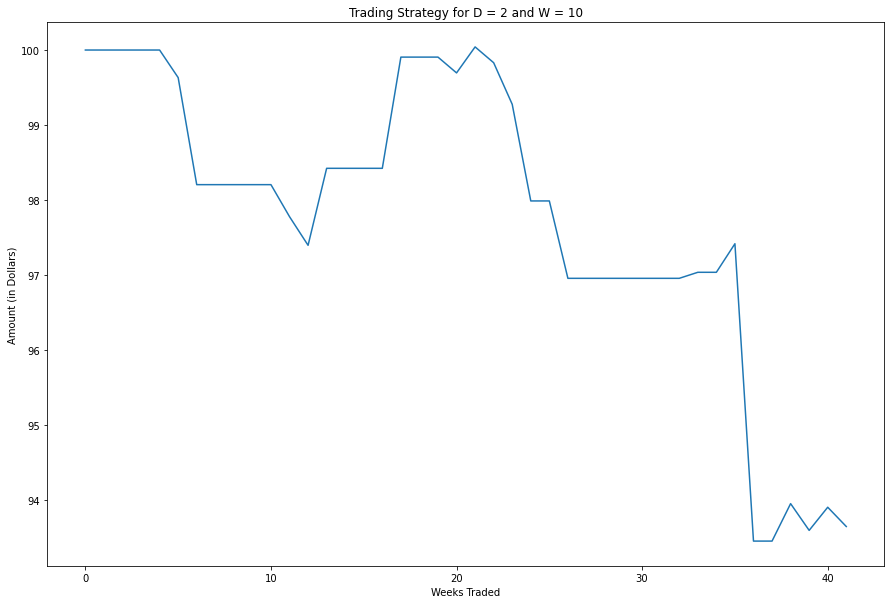

Accuracy for D = 3 for best W = 5 -> 36.17021276595745 %


<Figure size 432x288 with 0 Axes>

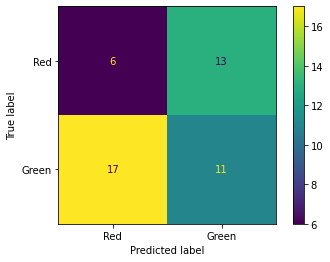

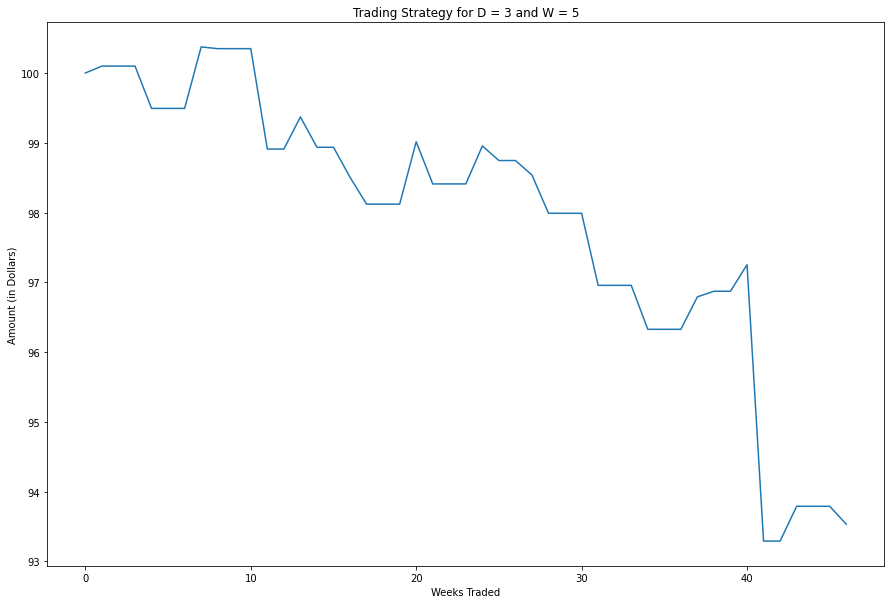

In [10]:
print("For Activision Blizzard -> ")
predict_for_year2_metrics(df_atvi_weekly_yr2, 1, 11)
predict_for_year2_metrics(df_atvi_weekly_yr2, 2, 10)
predict_for_year2_metrics(df_atvi_weekly_yr2, 3, 5)

For S&P 500 -> 
Accuracy for D = 1 for best W = 11 -> 26.82926829268293 %


<Figure size 432x288 with 0 Axes>

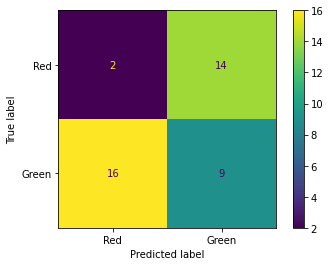

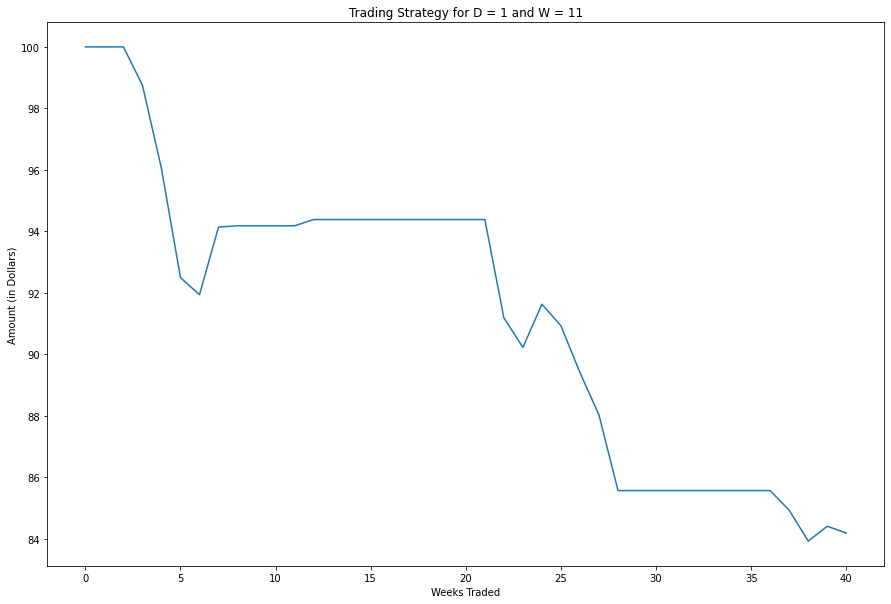

Accuracy for D = 2 for best W = 10 -> 38.095238095238095 %


<Figure size 432x288 with 0 Axes>

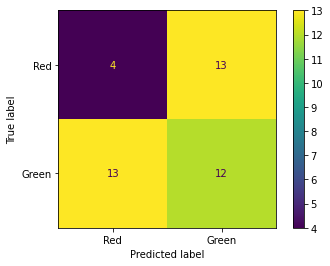

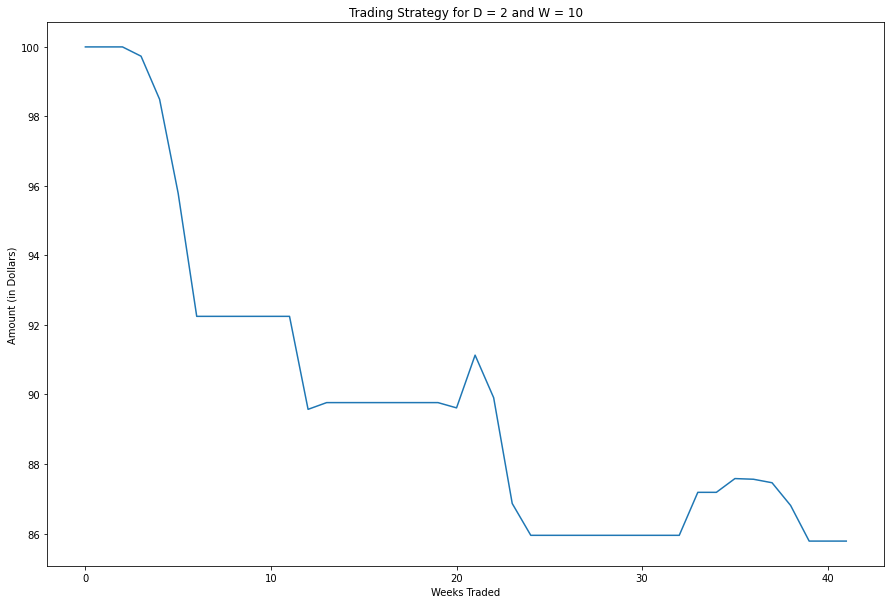

Accuracy for D = 3 for best W = 5 -> 40.42553191489361 %


<Figure size 432x288 with 0 Axes>

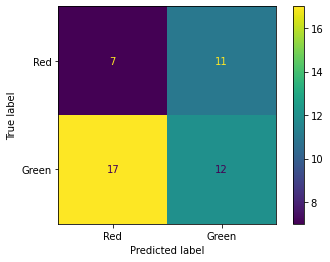

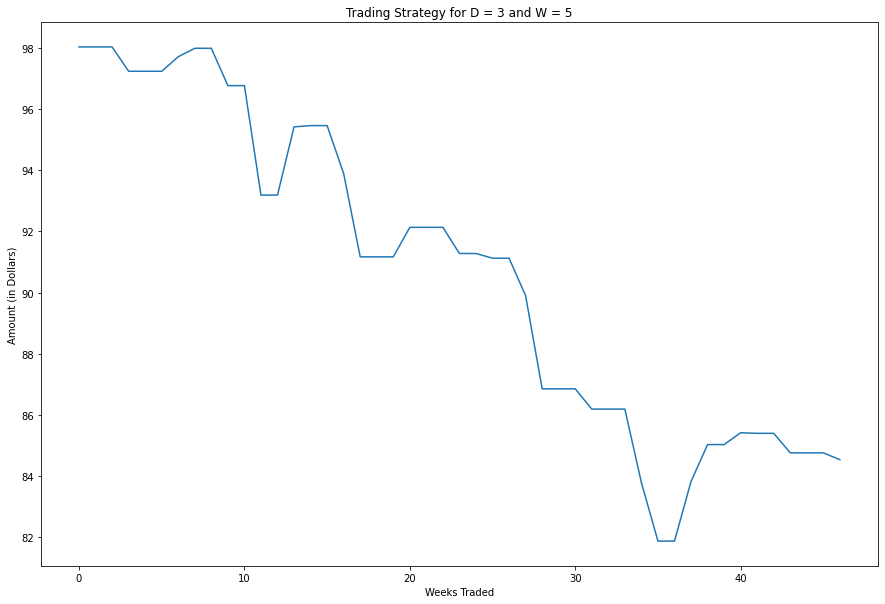

In [11]:
print("For S&P 500 -> ")
predict_for_year2_metrics(df_spy_weekly_yr2, 1, 11)
predict_for_year2_metrics(df_spy_weekly_yr2, 2, 10)
predict_for_year2_metrics(df_spy_weekly_yr2, 3, 5)